# Explanations and their comparison for DistilBERT model

Libraries and global variables

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pickle

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
CLASS_LABELS = ['bias', 'clickbait', 'conspiracy', 'fake', 'hate', 'junkscience', 'political', 'reliable', 'rumor', 'satire', 'unknown', 'unreliable']
MAIN_MODEL_PATH = './models/bert/main'
GSS_MODEL_PATHS = [f'./models/bert/clustering_gss/{i}' for i in range(7)]
LDA_MODEL_PATHS = [f'./models/bert/clustering_lda/{i}' for i in range(4)]
#DEVICE = "cuda:0"
DEVICE = "cpu"
device = torch.device(DEVICE)

Functions to load models

In [ ]:
def tokenize(text):
    """
    This functions tokenizes the input text.

    :param text: tekst tom tokenize
    :return:
    """
    return tokenizer(
        text,
        truncation = True,
        padding = 'max_length',
        max_length = 100,
        return_tensors = 'pt'
    )

In [ ]:
def load_model(path, device=device):
    """
    This function loads AutoModelForSequenceClassification from a given path.

    :param path: path to load model from
    :return:
    """
    model =  AutoModelForSequenceClassification.from_pretrained(path).to(device)

    setattr(model.config, "id2label", {
        i: CLASS_LABELS[i]
        for i in range(len(CLASS_LABELS))
    })

    setattr(model.config, "label2id", {
        CLASS_LABELS[i]: i
        for i in range(len(CLASS_LABELS))
    })

    return model

Loading dataset and selecting a subset to calculate explanations

In [ ]:
main_df = pd.read_csv("./preprocessed_datasets/main_df.csv", index_col=0)

# adding clustering results
clustering_lda = pd.read_csv("preprocessed_datasets/ldatfidf4_nouns.csv")
clustering_lda.columns = ["id","clustering_lda"]
clustering_gss = pd.read_csv("preprocessed_datasets/gssdmm7_nouns.csv")
clustering_gss.columns = ["id","clustering_gss"]

# joining
main_df = main_df.join(clustering_lda.set_index("id"), on = "id")
main_df = main_df.join(clustering_gss.set_index("id"), on = "id")

In [ ]:
main_df.head()[['content', 'clustering_lda', 'clustering_gss']]

In [ ]:
def select_random_rows(df, cluster_column, num_rows=15, random_state=42):
    """
    Function selects num_rows random rows for each cluster described in cluster_column.

    :param df: full dataframe
    :param cluster_column: column describing clusters
    :param num_rows: number of rows to return
    :param random_state: random state
    :return:
    """
    selected_rows = pd.DataFrame()
    np.random.seed(random_state)

    for cluster in df[cluster_column].unique():
        cluster_rows = df[df[cluster_column] == cluster]
        random_indices = np.random.choice(
            cluster_rows.index,
            size=min(num_rows, len(cluster_rows)),
            replace=False
        )
        selected_rows = pd.concat([selected_rows, df.loc[random_indices]])

    return selected_rows

In [ ]:
selected_texts = {}

In [ ]:
for clustering in ['clustering_lda', 'clustering_gss']:
    selected_texts[clustering] = {}
    for label in CLASS_LABELS:
        # one label will have full name finally
        if label == 'junkscience':
            news = select_random_rows(
                main_df[main_df.type == 'junksci'],
                clustering
            )
        else:
            news = select_random_rows(
                main_df[main_df.type == label],
                clustering
            )

        # split by cluster and save
        for cluster in news[clustering].unique():
            tmp = news[news[clustering] == cluster]
            tmp = tmp.content.tolist()
            tmp = [
                tokenizer.decode(tokenize(t)['input_ids'][0]).replace('[CLS]', '').replace('[SEP]', '')
                for t in tmp
            ]
            if label not in selected_texts[clustering].keys():
                selected_texts[clustering][label] = {}
            selected_texts[clustering][label][cluster] = tmp

In [ ]:
with open('./explanations/selected_news_for_explanations.pickle', 'wb') as f:
    pickle.dump(selected_texts, f)

Explaining predictions

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
import gc

In [ ]:
main_model = load_model(MAIN_MODEL_PATH)
main_model_explainer = SequenceClassificationExplainer(main_model, tokenizer)

In [ ]:
selected_texts_explanations = {}

In [ ]:
# create dictionary structure
for clustering in selected_texts.keys():
    if clustering not in selected_texts_explanations.keys():
        selected_texts_explanations[clustering] = {}

    for label in selected_texts[clustering].keys():
        if label not in selected_texts_explanations[clustering].keys():
            selected_texts_explanations[clustering][label] = {}

        for cluster in selected_texts[clustering][label].keys():
            if cluster not in selected_texts_explanations[clustering][label].keys():
                selected_texts_explanations[clustering][label][cluster] = []

In [ ]:
# running explanation
for clustering in selected_texts.keys():
    for label in selected_texts[clustering].keys():
        for cluster in selected_texts[clustering][label].keys():
            m_path = ''
            if clustering == 'clustering_lda':
                m_path = LDA_MODEL_PATHS[cluster]
            else:
                m_path = GSS_MODEL_PATHS[cluster]

            m = load_model(m_path)
            exp = SequenceClassificationExplainer(m, tokenizer)

            for t in selected_texts[clustering][label][cluster]:
                word_attributions = exp(t, class_name=label)
                word_attributions_main = main_model_explainer(t, class_name=label)
                selected_texts_explanations[clustering][label][cluster].append({
                    'main': word_attributions_main,
                    'local': word_attributions
                })

            del m
            del exp
            torch._C._cuda_clearCublasWorkspaces()
            torch._dynamo.reset()
            gc.collect()
            torch.cuda.empty_cache()

In [ ]:
with open('./explanations/selected_news_for_explanations_explanations_2.pickle', 'wb') as f:
    pickle.dump(selected_texts_explanations, f)

Visualisations

In [ ]:
# example
txt = selected_texts['clustering_lda']['political'][2][0]
word_attributions_main = main_model_explainer(txt, class_name='political')
main_model_explainer.visualize('./explanations/global.html')

m = load_model(LDA_MODEL_PATHS[2])
exp = SequenceClassificationExplainer(m, tokenizer)
word_attributions = exp(txt, class_name='political')
exp.visualize('./explanations/local.html')

Aggregated visualisations

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

In [2]:
CLASS_LABELS = ['bias', 'clickbait', 'conspiracy', 'fake', 'hate', 'junkscience', 'political', 'reliable', 'rumor', 'satire', 'unknown', 'unreliable']
GSS_CLUSTERS = 7
LDA_CLUSTERS = 4

In [3]:
with open('./explanations/selected_news_for_explanations_explanations_2.pickle', 'rb') as f:
    selected_texts_explanations = pickle.load(f)

In [4]:
wilcoxon_test = {}

In [5]:
# create dictionary structure
for clustering in selected_texts_explanations.keys():
    if clustering not in wilcoxon_test.keys():
        wilcoxon_test[clustering] = {}

    for label in selected_texts_explanations[clustering].keys():
        if label not in wilcoxon_test[clustering].keys():
            wilcoxon_test[clustering][label] = {}

        for cluster in selected_texts_explanations[clustering][label].keys():
            if cluster not in wilcoxon_test[clustering][label].keys():
                wilcoxon_test[clustering][label][cluster] = []

In [6]:
# calculate p-values
for clustering in selected_texts_explanations.keys():
    for label in selected_texts_explanations[clustering].keys():
        for cluster in selected_texts_explanations[clustering][label].keys():
            if len(selected_texts_explanations[clustering][label][cluster]) == 0:
                wilcoxon_test[clustering][label][cluster] = [1]
            else:
                for t in selected_texts_explanations[clustering][label][cluster]:
                    # Wilcoxon p-value calculation
                    t1 = [q[1] for q in t['main']]
                    t2 = [q[1] for q in t['local']]
                    wilcoxon_test[clustering][label][cluster].append(
                        wilcoxon(t1, t2)[1]
                    )

In [7]:
def fdr_correction_critical_value(p_values, alpha=0.05):
    """
    Perform Benjamini-Hochberg False Discovery Rate (FDR) correction and return the critical value.

    Parameters:
    - p_values: List or array of p-values
    - alpha: Significance level

    Returns:
    - critical_value: The critical value (p-value threshold)
    """
    sorted_indices = sorted(range(len(p_values)), key=lambda i: p_values[i])
    sorted_p_values = [p_values[i] for i in sorted_indices]

    m = len(p_values)
    c = alpha / m
    reject = [p <= (i + 1) * c for i, p in enumerate(sorted_p_values)]
    k_max = max(i for i, r in enumerate(reject) if r)

    critical_value = (k_max + 1) * c
    return critical_value

In [8]:
def transform_one_class(dct, class_name):
    """
    This function transforms results from one class into a dataframe.
    :param dct: dictionary with results
    :param class_name: class name
    :return:
    """
    out = pd.melt(
        pd.DataFrame.from_dict(dct[class_name], orient='index').reset_index(),
        id_vars='index'
    )[['index', 'value']]
    out.columns = ['cluster', 'value']
    out['label'] = class_name
    return out

In [9]:
def transform_results(dct, p_value=0.05):
    """
    This function transforms results from all classes into a dataframe.
    :param dct: dictionary with results
    :param p_value: p-value threshold
    :return:
    """
    out = pd.concat([transform_one_class(dct, cls) for cls in CLASS_LABELS])
    critical_p_value = fdr_correction_critical_value(out.value.tolist(), p_value)
    out['reject'] = out.value < critical_p_value
    out = out.groupby(['cluster', 'label'])['reject'].sum().reset_index()
    out.reject = out.reject / 15 # 15 is the number of news per cluster - hardcoded also earlier

    out.columns = ['cluster', 'label', 'rate of rejected hypotheses']
    heatmap_data = out.pivot(index='label', columns='cluster', values='rate of rejected hypotheses')

    return heatmap_data

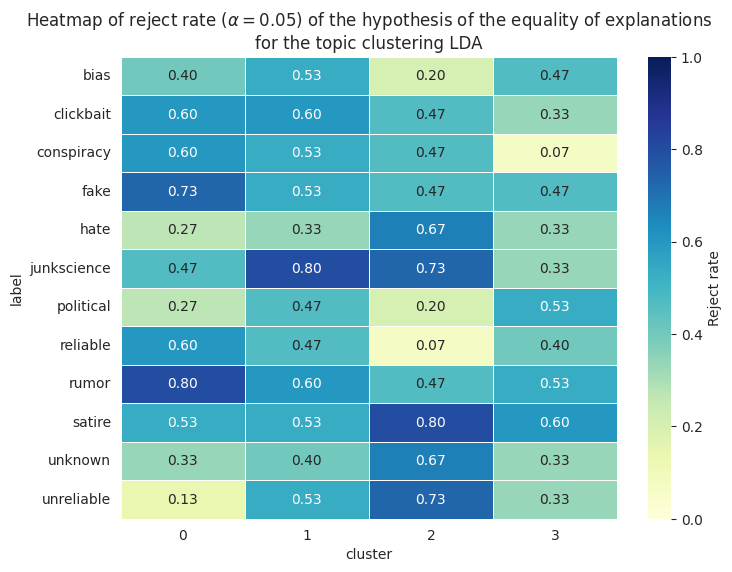

In [10]:
heatmap_data = transform_results(wilcoxon_test['clustering_lda'])

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Reject rate'}, linewidths=.5, vmin=0, vmax=1)
plt.title('Heatmap of reject rate ($α=0.05$) of the hypothesis of the equality of explanations\nfor the topic clustering LDA')
plt.savefig('./explanations/lda_res.png')
plt.show()

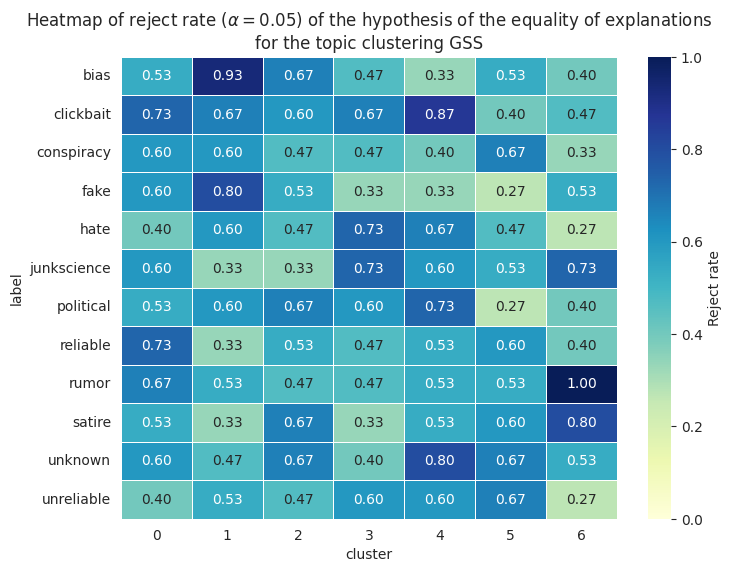

In [11]:
heatmap_data = transform_results(wilcoxon_test['clustering_gss'])

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Reject rate'}, linewidths=.5, vmin=0, vmax=1)
plt.title('Heatmap of reject rate ($α=0.05$) of the hypothesis of the equality of explanations\nfor the topic clustering GSS')
plt.savefig('./explanations/gss_res.png')
plt.show()